# Proyecto Big Data

Para el presente proyecto se analizaran dos datasets los cuales corresponde a datos de vehiculos electricos que se encuentra registrados apartir del año 2020 y de sobre las estaciones de carga de la zona.

Se utilizaran los datos para realizar una prediccion supervisada para predecir si un codigo postal tiene suficientes estaciones de carga para poder abastecer a la pobacion de vehiculos electricos.

In [31]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType, LongType, TimestampType, DateType, StructType, StructField, StringType
from pyspark.sql.functions import col, desc, min, max, rand, when, avg, count
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import itertools
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
spark = SparkSession \
    .builder \
    .appName("Proyecto") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/11 13:31:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


Primero se debera de crear la sesion de pyspark que esto se realizara con el codigo anterior, y seguidamente se debera de cargar el conjunto de datos para realizar la exploracion de los datos.

In [3]:
df_electric_vehicles_stations = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("dbtable", "joined_data") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .load()

df_electric_vehicles_stations.show()

+-----------+----------+-------------+--------------------+---------------------+------------------+-----+-------------+------------------+------------------+------------------+-------------------+------------------+
|Postal Code|      Make|vehicle_count|avg_vehicle_latitude|avg_vehicle_longitude|avg_electric_range|  ZIP|station_count|   level2_chargers|  dc_fast_chargers|  station_latitude|  station_longitude|   avg_distance_km|
+-----------+----------+-------------+--------------------+---------------------+------------------+-----+-------------+------------------+------------------+------------------+-------------------+------------------+
|      98270|     TESLA|          688|   48.06113999999989|            -122.1769|16.976744186046513|98270|            3| 7.965681818181819|11.383863080684597|48.042471240430054|-122.15625499558398| 2.581474911404132|
|      98684|       BMW|           29|   45.63700999999999|           -122.48723| 31.79310344827586|98684|            8| 14.03431818

Los datos que se cargaron es la union y el tratamiento de los datasets de "alt_fuel_stations.csv" que corresponde a estaciones de servicio y de "Electric_Vehicle_Population_Data.csv" que son la poblacion de vehiculos electricos, los cuales fueron agrupados por medio de "Postal Code" y "Make", esto por el motivo que:

- Si se utilizan mas elementos de agrupacion puede que exista una granulidad en los datos.
- Al utilizar la agrupacion actual se evita que queden grupos muy pequeños.

Al tener estos puntos en cuenta se debera de realizar la prediccion supervisada de que si los conductores de un vehículo eléctrico poseen estaciones de carga suficientes para abastecer las zona en la que se encuentran por medio de su código postal que se encuentra, para esto se utilizara una columna que llevara el nombre de 'Acceso' y esta sera true o false de acuerdo a si tiene o no un buen acceso para abastecer la carga del vehículo, para esto se utilizara como una referencia que por cada 4 vehiculos debera de existir una estacion de carga cercana tomando en cuenta la cercania promedio que se obtuvo.

In [4]:
for column in df_electric_vehicles_stations.columns:
    null_count = df_electric_vehicles_stations.filter(col(column).isNull()).count()
    zero_count = df_electric_vehicles_stations.filter(col(column) == 0).count()
        
    print(f"\nColumna: {column}")
    print(f"Valores NULL: {null_count}")
    print(f"Valores cero: {zero_count}")


Columna: Postal Code
Valores NULL: 0
Valores cero: 0

Columna: Make
Valores NULL: 0
Valores cero: 0

Columna: vehicle_count
Valores NULL: 0
Valores cero: 0

Columna: avg_vehicle_latitude
Valores NULL: 9
Valores cero: 0

Columna: avg_vehicle_longitude
Valores NULL: 9
Valores cero: 0

Columna: avg_electric_range
Valores NULL: 1
Valores cero: 2532

Columna: ZIP
Valores NULL: 2572
Valores cero: 0

Columna: station_count
Valores NULL: 0
Valores cero: 2572

Columna: level2_chargers
Valores NULL: 0
Valores cero: 2572

Columna: dc_fast_chargers
Valores NULL: 0
Valores cero: 2572

Columna: station_latitude
Valores NULL: 2572
Valores cero: 0

Columna: station_longitude
Valores NULL: 2572
Valores cero: 0

Columna: avg_distance_km
Valores NULL: 0
Valores cero: 2572


Para los valores en cero o valores nulos en las columnas, solo se eliminara la columna "ZIP" ya que esta columna es lo mismo que "Postal Code" y no brinda ningun tipo de dato valioso. Y para los valores en 0 que se presentan no se les dara tratamiento ya que estos valores son valores indican que son vehiculos a los cuales no se tienen ninguna estacion en su zona por medio del codigo postal, lo que indicaria que estos vehiculos deberan de movilizarce a otra zona.

Para los valores nulos se les asignara un valor aleatorio que se encuentre dentro del conjunto de datos.


Estadísticas para avg_electric_range:
Límite inferior: -42.75
Límite superior: 75.57
Número de outliers: 510

Estadísticas para station_count:
Límite inferior: -9.00
Límite superior: 15.00
Número de outliers: 1099

Estadísticas para level2_chargers:
Límite inferior: -19.97
Límite superior: 33.28
Número de outliers: 1060

Estadísticas para dc_fast_chargers:
Límite inferior: -34.15
Límite superior: 56.92
Número de outliers: 1099


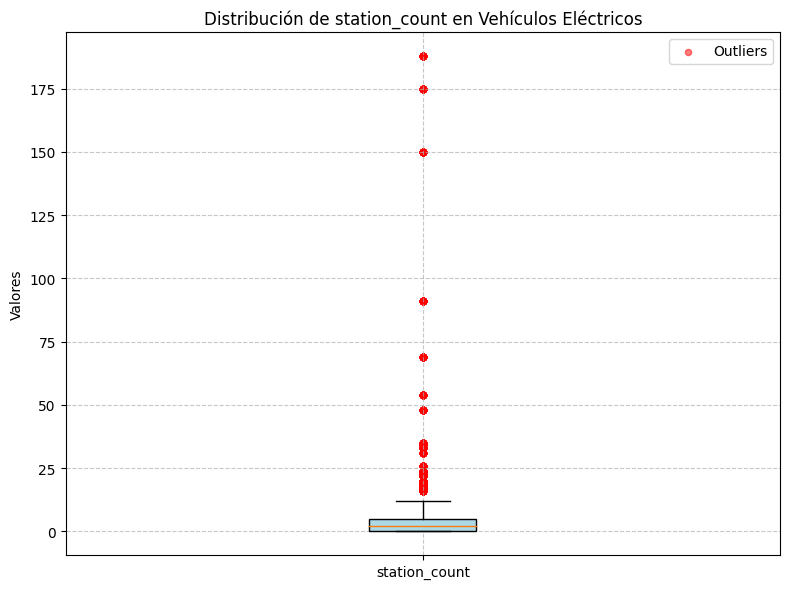

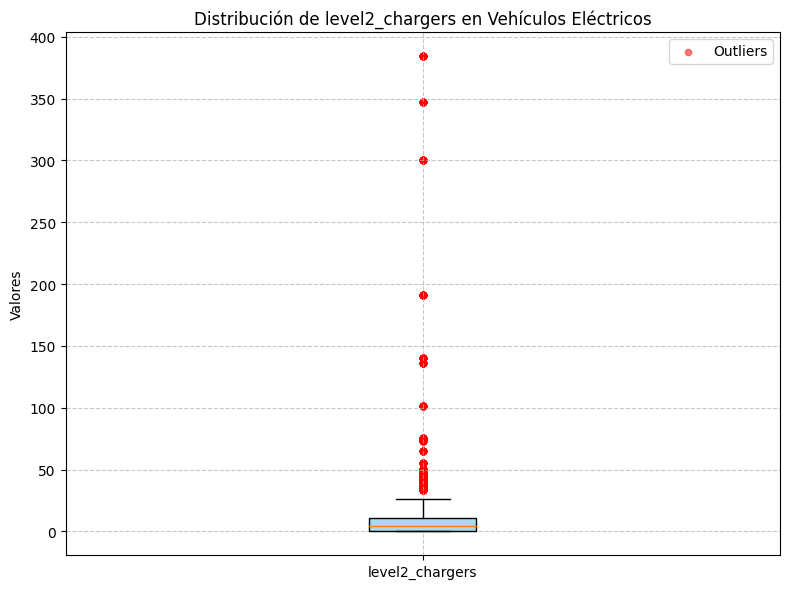

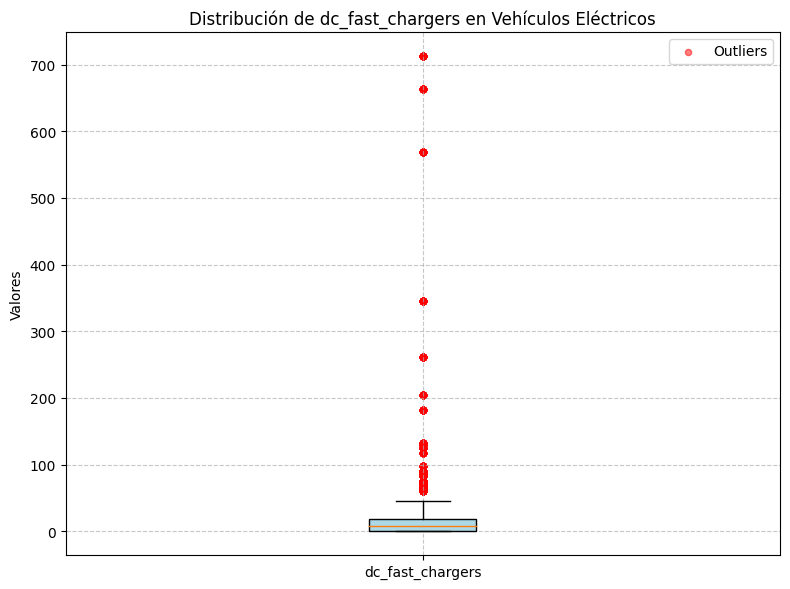

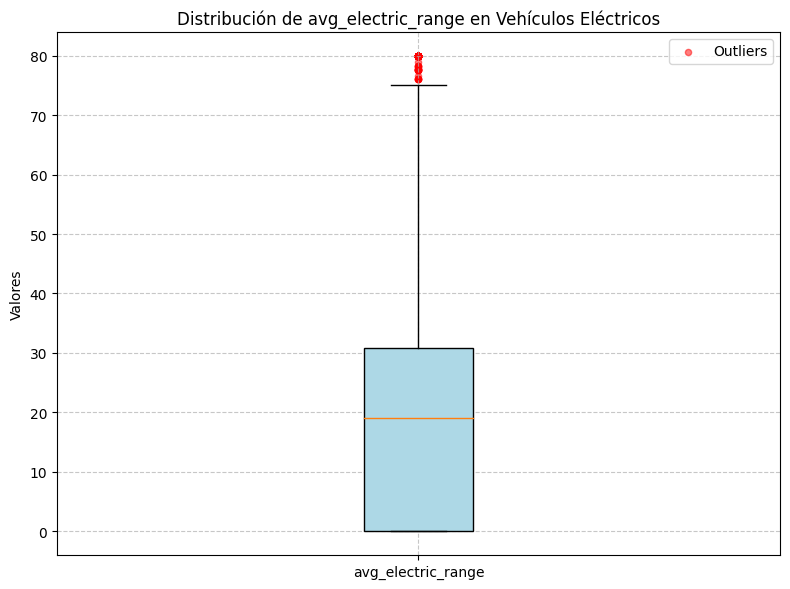

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
def plot_ev_boxplot(df, numerical_columns):
    figures = [] 
    
    for column in numerical_columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        
        non_null_df = df.filter(col(column).isNotNull())
        
        if non_null_df.count() == 0:
            print(f"Skipping {column} - no non-null values")
            plt.close(fig)
            continue
            
        quantiles = non_null_df.approxQuantile(column, [0.25, 0.75], 0.05)
        Q1 = quantiles[0]
        Q3 = quantiles[1]
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        filtered_data = non_null_df.filter(
            (col(column) >= lower_bound) & 
            (col(column) <= upper_bound)
        ).select(column).rdd.flatMap(lambda x: x).collect()
        
        outliers = non_null_df.filter(
            (col(column) < lower_bound) | 
            (col(column) > upper_bound)
        ).select(column).rdd.flatMap(lambda x: x).collect()
        
        print(f"\nEstadísticas para {column}:")
        print(f"Límite inferior: {lower_bound:.2f}")
        print(f"Límite superior: {upper_bound:.2f}")
        print(f"Número de outliers: {len(outliers)}")
        
        if not filtered_data:
            print(f"No valid data for {column}")
            plt.close(fig)
            continue
        
        bplot = ax.boxplot([filtered_data], 
                          labels=[column],
                          patch_artist=True,
                          showfliers=False)

        if outliers:
            ax.scatter([1] * len(outliers), outliers, 
                      color='red', alpha=0.5, s=20, label='Outliers')
            ax.legend()
        
        bplot['boxes'][0].set_facecolor('lightblue')
        
        plt.title(f'Distribución de {column} en Vehículos Eléctricos')
        plt.ylabel('Valores')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        figures.append(fig)
    
    return figures


numerical_columns = [
    'avg_electric_range', 
    'station_count',
    'level2_chargers', 
    'dc_fast_chargers',
]

figs = plot_ev_boxplot(df_electric_vehicles_stations, numerical_columns)

for fig in figs:
    plt.figure(fig.number)
    plt.show()

Para los outliers se no se les realizara tratamiento, esto debido a que algunas zonas postales son mas grandes que otras por lo tanto van a contar con mas vehiculos, tambien que son diferentes tipos de vehiculos por lo que cuentan con autonomias diferentes, tambien que en la fase anterior del proyecto se realizo un tratamiento de estos valores en pyspark.

In [6]:
df_electric_vehicles_stations = df_electric_vehicles_stations.drop("ZIP")
df_electric_vehicles_stations.show()

+-----------+----------+-------------+--------------------+---------------------+------------------+-------------+------------------+------------------+------------------+-------------------+------------------+
|Postal Code|      Make|vehicle_count|avg_vehicle_latitude|avg_vehicle_longitude|avg_electric_range|station_count|   level2_chargers|  dc_fast_chargers|  station_latitude|  station_longitude|   avg_distance_km|
+-----------+----------+-------------+--------------------+---------------------+------------------+-------------+------------------+------------------+------------------+-------------------+------------------+
|      98270|     TESLA|          688|   48.06113999999989|            -122.1769|16.976744186046513|            3| 7.965681818181819|11.383863080684597|48.042471240430054|-122.15625499558398| 2.581474911404132|
|      98684|       BMW|           29|   45.63700999999999|           -122.48723| 31.79310344827586|            8| 14.03431818181818|30.356968215158926|    

In [7]:
median_lat = df_electric_vehicles_stations.approxQuantile("avg_vehicle_latitude", [0.5], 0.01)[0]
median_lon = df_electric_vehicles_stations.approxQuantile("avg_vehicle_longitude", [0.5], 0.01)[0]
median_range = df_electric_vehicles_stations.approxQuantile("avg_electric_range", [0.5], 0.01)[0]

df_electric_vehicles_stations = df_electric_vehicles_stations.fillna({
    "avg_vehicle_latitude": median_lat,
    "avg_vehicle_longitude": median_lon,
    "avg_electric_range": median_range
})

df_electric_vehicles_stations.select(
    count(when(col("avg_vehicle_latitude").isNull(), True)).alias("null_lat"),
    count(when(col("avg_vehicle_longitude").isNull(), True)).alias("null_lon"),
    count(when(col("avg_electric_range").isNull(), True)).alias("null_range")
).show()

+--------+--------+----------+
|null_lat|null_lon|null_range|
+--------+--------+----------+
|       0|       0|         0|
+--------+--------+----------+



In [8]:
df_electric_vehicles_stations = df_electric_vehicles_stations.fillna({
    "station_latitude": 0,
    "station_longitude": 0
})

df_electric_vehicles_stations.select(
    count(when(col("station_latitude").isNull(), True)).alias("null_lat"),
    count(when(col("station_longitude").isNull(), True)).alias("null_lon")
).show()

+--------+--------+
|null_lat|null_lon|
+--------+--------+
|       0|       0|
+--------+--------+



25/05/11 13:32:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


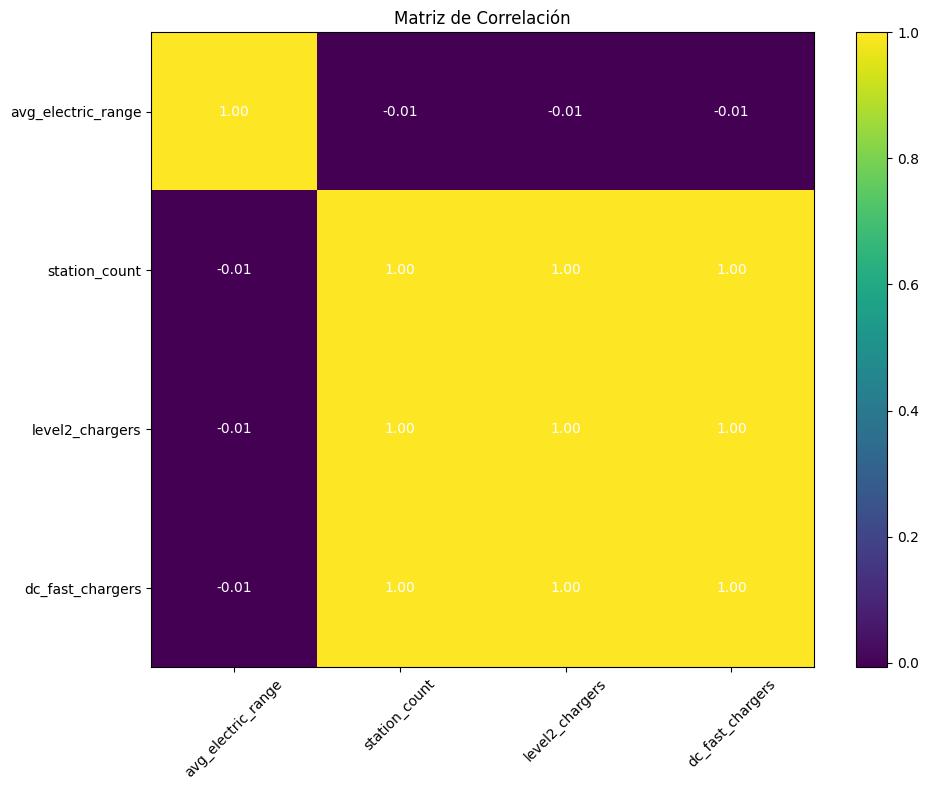

In [9]:
vector_assembler = VectorAssembler(
    inputCols=numerical_columns,
    outputCol="features"
)
vector_df = vector_assembler.transform(df_electric_vehicles_stations)

vehicles_matrix = Correlation.corr(vector_df, "features").collect()[0][0]
correlation_matrix = vehicles_matrix.toArray()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', aspect='auto')

for i in range(len(numerical_columns)):
    for j in range(len(numerical_columns)):
        plt.text(j, i, f"{float(correlation_matrix[i][j]):.2f}", 
                ha="center", va="center", color='white')


plt.colorbar()
plt.xticks(range(len(numerical_columns)), numerical_columns, rotation=45)
plt.yticks(range(len(numerical_columns)), numerical_columns)
plt.title("Matriz de Correlación")
plt.tight_layout()

plt.show()

Al observar la matriz de correlacion se puede observar que es una matriz diferente donde parece que la mayoria de los datos que posee son casi perfectos y que estan correlacionados entre si, lo cual genera duda de que los datos esten casi perfectamente correlacionados entre si, por lo que se realizarn algunos graficos de dispersion para poder confirmar que los datos si cuenten con estas correlaciones.

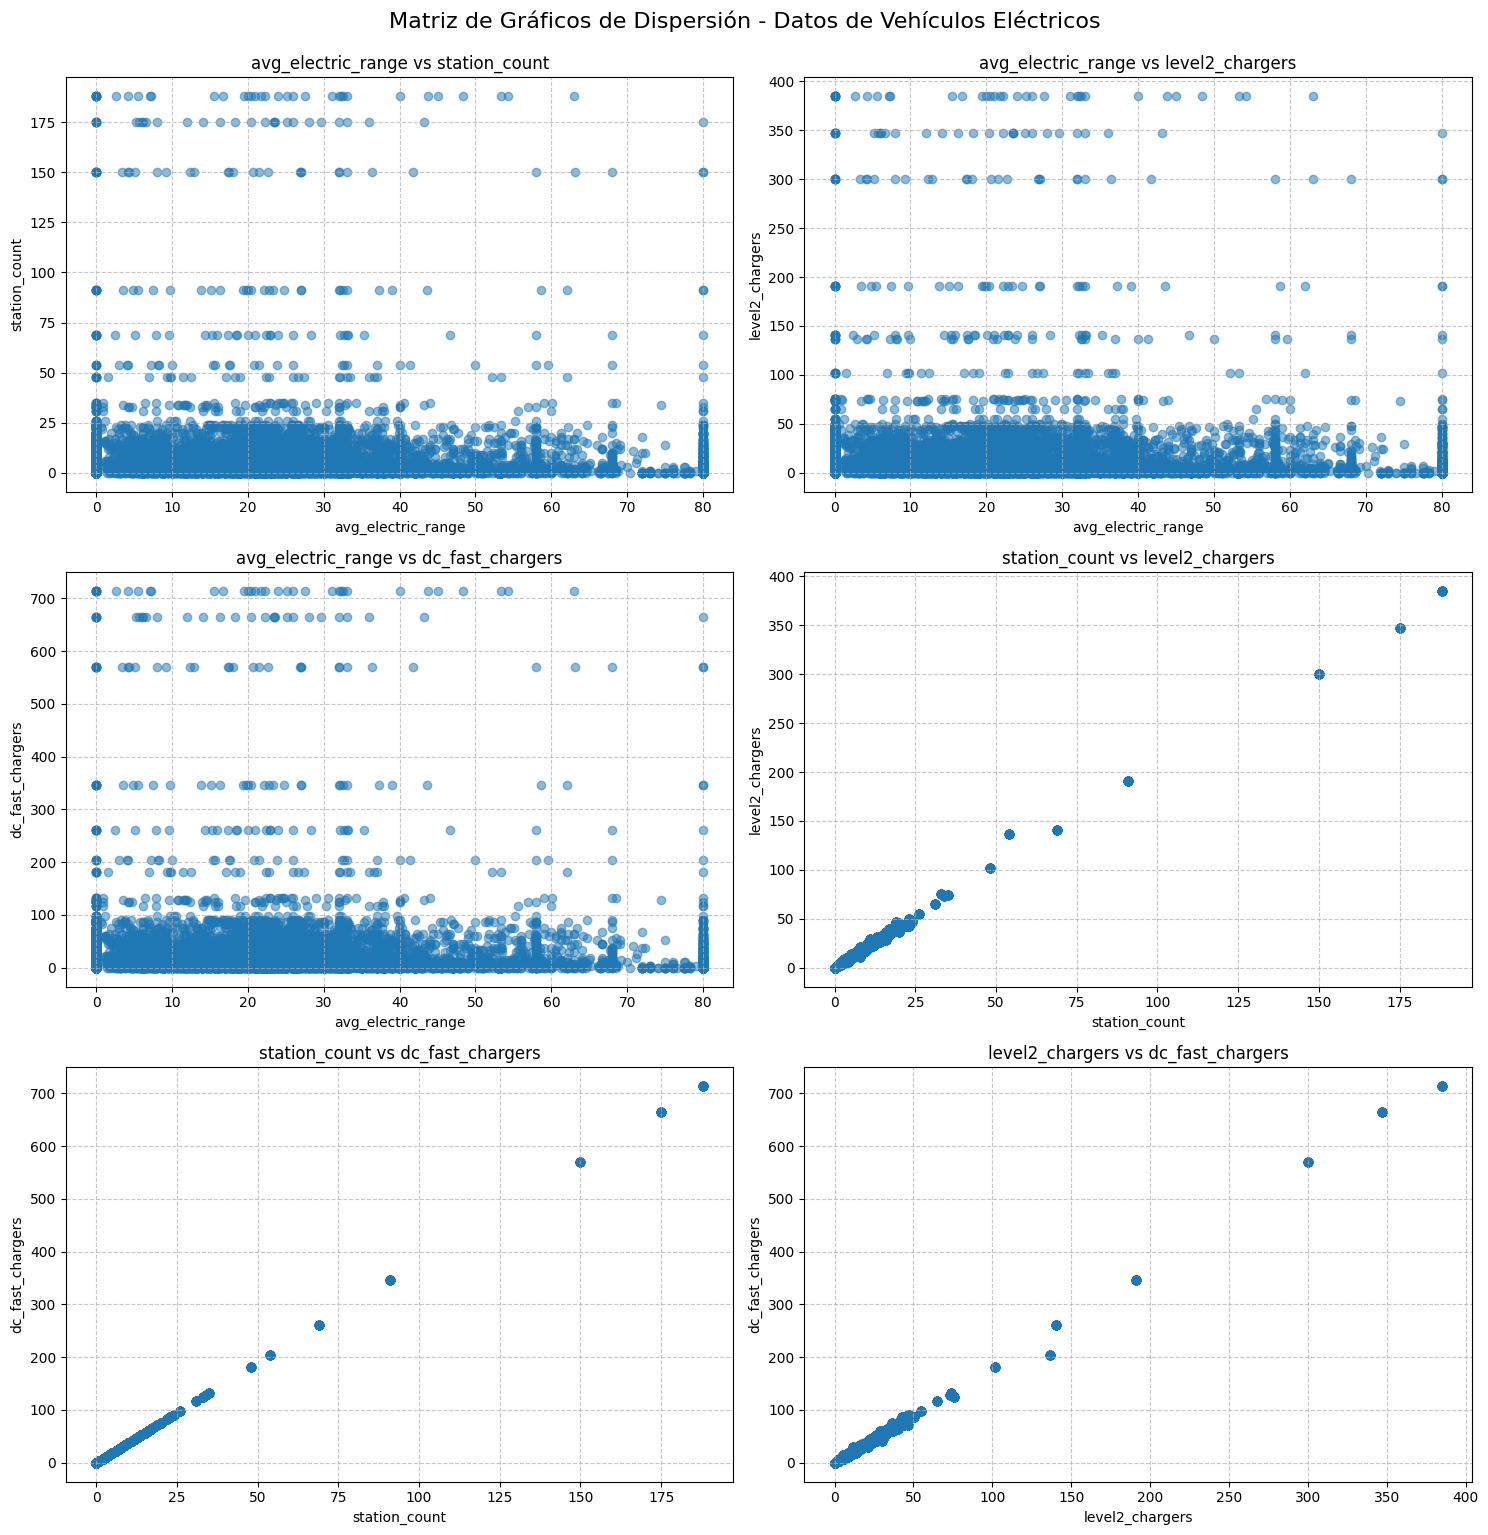

In [10]:
pairs = list(itertools.combinations(numerical_columns, 2))

num_pairs = len(pairs)
num_cols = 2
num_rows = (num_pairs + 1) // 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

for i, (col1, col2) in enumerate(pairs):
    data_pair = df_electric_vehicles_stations.select(col1, col2).collect()
    x_values = [row[col1] for row in data_pair]
    y_values = [row[col2] for row in data_pair]
    
    axes[i].scatter(x_values, y_values, alpha=0.5)
    axes[i].set_xlabel(col1)
    axes[i].set_ylabel(col2)
    axes[i].set_title(f"{col1} vs {col2}")
    axes[i].grid(True, linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle("Matriz de Gráficos de Dispersión - Datos de Vehículos Eléctricos", y=1.02, fontsize=16)
plt.show()

Al realizar los graficos de dipersion, el cual se puede observar que los datos comparados de la siguiente manera:

- station_count vs level2_chargers
- station_count vs dc_fast_chargers
- level2_chargers vs dc_fast_chargers

Se encuentran correlacionados de manera perfecta confirmando lo que se mostro en la matriz de correlacion, indicando que los datos son lineales y tienen una relacion matematica la cual es practicamente exacta, la cual tiene sentido ya que son cargadores de vehiculos y estaciones, por lo cual se puede decir que las estaciones tienen cantidades de cargadores ed ambos tipos que son proporcionales.

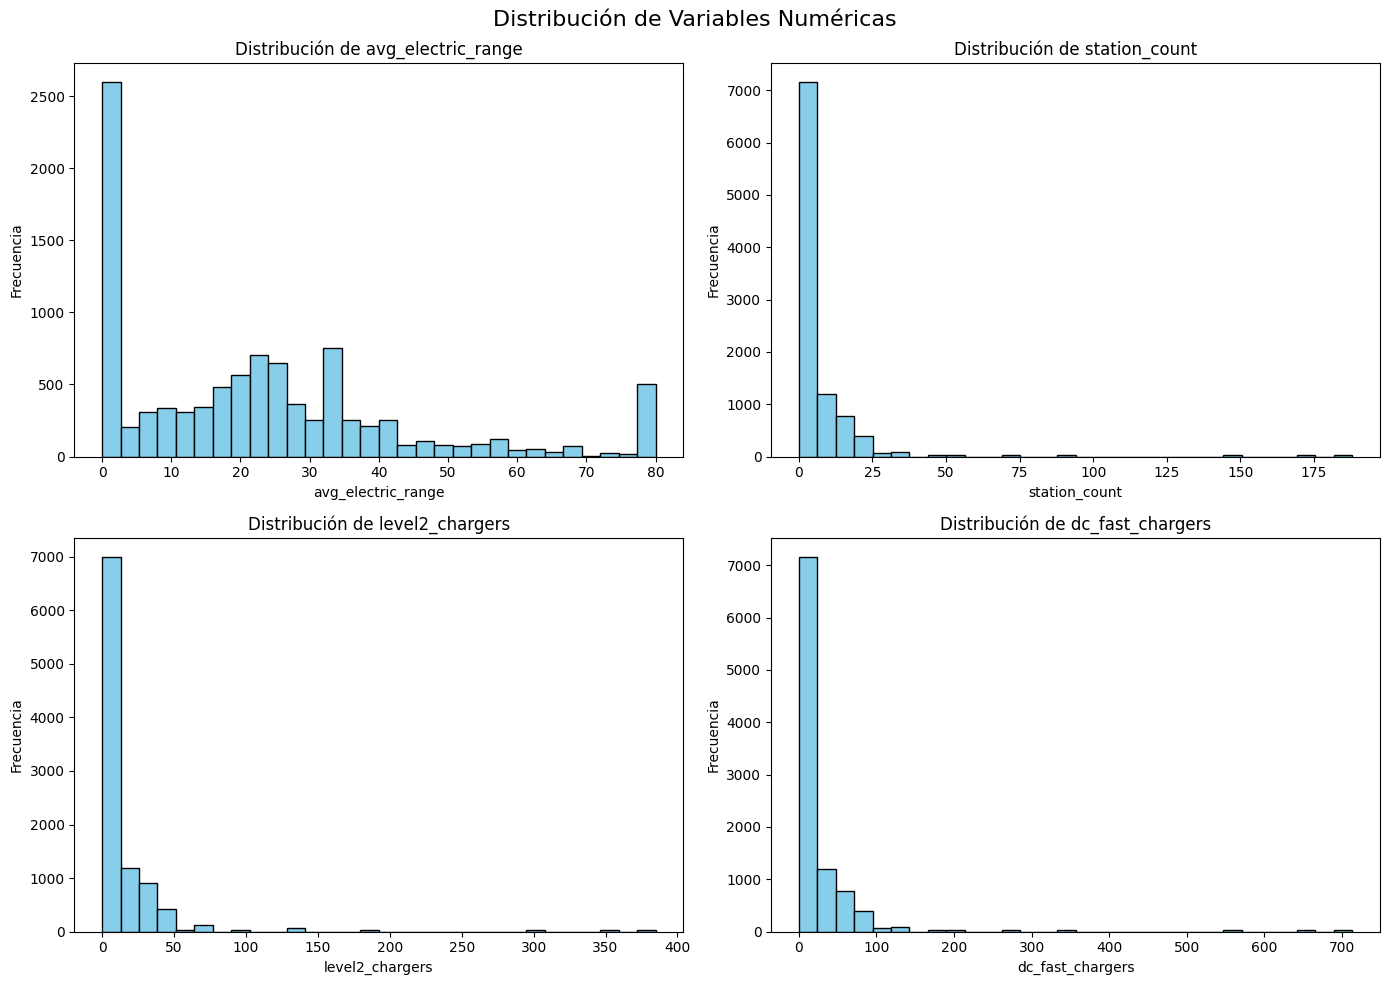

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribución de Variables Numéricas', fontsize=16)

for i, col in enumerate(numerical_columns):
    data = df_electric_vehicles_stations.select(col).rdd.flatMap(lambda x: x).collect()
    
    ax = axes[i//2, i%2]
    
    ax.hist(data, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

De acuerdo a los histogramas que se crearon se puede observar que:

- Para la autonomia electrica se puede observar que hay varios picos, uno en 0 donde se puede concluir que son vehiculos hibridos, que no son del todo electricos y los otros picos que se observan son en 35 aproximadamente y en 80.
- Para las estasciones de carga y los tipods de cargadores poseen distribuciones muy asimetricas, donde una gran cantidad de localidades no poseen estaciones de carga y por lo tanto no poseen cargadores electricos.

Con respecto a los histogramas de las estaciones d ecarga y los tipos de cargadores nos puede indicar que se puede hacer una inversion de infraestructura para construir mas estaciones de cargas.

Se utilizaran dos modelos para realizar la prediccion que se planteo, se va a utilizar como primer modelo un decision tree.

In [25]:
features = [
    "vehicle_count", 
    "avg_electric_range",
    "station_count",
    "level2_chargers",
    "dc_fast_chargers",
    "avg_distance_km"
]

df_decision_tree = df_electric_vehicles_stations.withColumn(
    "Acceso",
    when(
        (col("station_count") >= col("vehicle_count")/4) & 
        (col("avg_distance_km") <= 5.0),
        1.0
    ).otherwise(0.0)
)

assembler = VectorAssembler(inputCols=features, outputCol="features")
data_decision_tree = assembler.transform(df_decision_tree)

train_data_decision, test_data_decision = data_decision_tree.randomSplit([0.7, 0.3], seed=42)

dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="Acceso",
    seed=42
)

evaluator_auc_decision = BinaryClassificationEvaluator(
    labelCol="Acceso",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

evaluator_accuracy_decision = MulticlassClassificationEvaluator(
    labelCol="Acceso",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1_decision = MulticlassClassificationEvaluator(
    labelCol="Acceso",
    predictionCol="prediction",
    metricName="f1"
)

paramGrid_decision = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7, 10]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 5]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()

crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid_decision,
    evaluator=evaluator_auc_decision,
    numFolds=5,
    seed=42
)

cv_model_decision = crossval.fit(train_data_decision)

best_model_decision = cv_model_decision.bestModel
print("\nMejores parámetros:")
print(f"MaxDepth: {best_model_decision.getMaxDepth()}")
print(f"MinInstancesPerNode: {best_model_decision.getMinInstancesPerNode()}")
print(f"Impurity: {best_model_decision.getImpurity()}")

predictions_decision = cv_model_decision.transform(test_data_decision)

auc_decision = evaluator_auc_decision.evaluate(predictions_decision)
print(f"\nAUC-ROC: {auc_decision:.4f}")

accuracy_decision = evaluator_accuracy_decision.evaluate(predictions_decision)
print(f"Accuracy: {accuracy_decision:.4f}")

f1_decision = evaluator_f1_decision.evaluate(predictions_decision)
print(f"F1 Score: {f1_decision:.4f}")

prediction_and_labels_decision = predictions_decision.select("prediction", "Acceso") \
    .withColumn("Acceso", col("Acceso").cast(DoubleType())) \
    .rdd.map(lambda row: (float(row['prediction']), float(row['Acceso'])))

metrics_decision = MulticlassMetrics(prediction_and_labels_decision)

confusion_matrix_decision = metrics_decision.confusionMatrix().toArray()
print("\nMatriz de Confusión:")
print("          Predicción 0  Predicción 1")
print(f"Realidad 0: {confusion_matrix_decision[0][0]:.0f}         {confusion_matrix_decision[0][1]:.0f}")
print(f"Realidad 1: {confusion_matrix_decision[1][0]:.0f}         {confusion_matrix_decision[1][1]:.0f}")

tn_decision = confusion_matrix_decision[0][0]
fp_decision = confusion_matrix_decision[0][1]
fn_decision = confusion_matrix_decision[1][0]
tp_decision = confusion_matrix_decision[1][1]

precision_decision = tp_decision / (tp_decision + fp_decision)
recall_decision = tp_decision / (tp_decision + fn_decision)
specificity_decison = tn_decision / (tn_decision + fp_decision)

print(f"\nPrecisión: {precision_decision:.4f}")
print(f"Recall: {recall_decision:.4f}")
print(f"Especificidad: {specificity_decison:.4f}")

predictions_labeled_decision = predictions_decision.withColumn(
    "Resultado_Acceso",
    when(col("prediction") == 1.0, "Suficiente")
    .otherwise("Insuficiente")
)

predictions_detailed_decision = predictions_labeled_decision.select(
    "Postal Code",
    "Make",
    "vehicle_count",
    "station_count",
    "level2_chargers",
    "dc_fast_chargers",
    "avg_distance_km",
    "Acceso",
    "prediction",
    "Resultado_Acceso",
    "probability"
).dropDuplicates(["Postal Code"])

print("\nEjemplo de predicciones:")
predictions_detailed_decision.show(5, truncate=False)


Mejores parámetros:
MaxDepth: 10
MinInstancesPerNode: 5
Impurity: gini

AUC-ROC: 0.9991
Accuracy: 0.9920
F1 Score: 0.9920

Matriz de Confusión:
          Predicción 0  Predicción 1
Realidad 0: 1871         8
Realidad 1: 15         977

Precisión: 0.9919
Recall: 0.9849
Especificidad: 0.9957

Ejemplo de predicciones:
+-----------+-----+-------------+-------------+---------------+----------------+---------------+------+----------+----------------+-----------+
|Postal Code|Make |vehicle_count|station_count|level2_chargers|dc_fast_chargers|avg_distance_km|Acceso|prediction|Resultado_Acceso|probability|
+-----------+-----+-------------+-------------+---------------+----------------+---------------+------+----------+----------------+-----------+
|10023      |TESLA|1            |0            |0.0            |0.0             |0.0            |0.0   |0.0       |Insuficiente    |[1.0,0.0]  |
|12833      |TESLA|1            |0            |0.0            |0.0             |0.0            |0.0   |0.0

Como primer modelo se utilizo un decision treepor ser simple y facil de utilizar, para evaluar el modelo se utilizaron varias metricas:

- AUC-ROC: esta metrica nos indica que tan bien el modelo puede diferenciar entre dos clases, en este caso entre Acceso Suficiente e Insuficiente.
- Accuracy: es la exactitud con la que el modelo puede clasificar.
- F1 score: indica cuantos clasifico como reales y efectivamente eran reales.

Tambien se muestra una matriz de confusion la cual muestra los siguientes datos:

- Verdaderos Negativos (TN) = 1871, nos indica que el modelo logro clasificar 1871 registros cuando era un acceso insuficiente.
- Falsos Positivos (FP) = 8, el modelo nos indica que clasifico 8 registros como acceso suficiente pero en realidad era acceso insuficiente.
- Falsos Negativos (FN) = 15, el modelo clasifico 15 registros como acceso insuficiente pero en realidad era suficiente.
- Verdaderos Positivos (TP) = 977, el modelo clasifico 977 registros como suficientes y efectivamente eran suficientes

Tambien se evaluaron las siguientes metricas:

- Precisión: nos indica que el modelo en un 0.99 de las veces clasifico de manera correcta los casos.
- Recall: nos indica que en un 0.98% de los casos que eran positivos los detecto como tales.
- Especificidad: nos indica que de un 0.99% de los casos que realmente eran negativos este los detecta como tales.

Con este modelo se utilizo la metrica Gini la cual es una metrica que es utilizada en los arboles de decision, para medir que tan mezcladas estan las clases en el conjunto de datos. Esto nos indica que tantos registros de Acceso Suficiente e Insuficiente se encuentran.

In [36]:
features = [
    "vehicle_count", 
    "avg_electric_range",
    "station_count",
    "level2_chargers",
    "dc_fast_chargers",
    "avg_distance_km"
]

df_nb = df_electric_vehicles_stations.withColumn(
    "Acceso",
    when(
        (col("station_count") >= col("vehicle_count")/4) & 
        (col("avg_distance_km") <= 5.0),
        1.0
    ).otherwise(0.0)
)

assembler = VectorAssembler(inputCols=features, outputCol="features")
data_nb = assembler.transform(df_nb)

train_data_nb, test_data_nb = data_nb.randomSplit([0.7, 0.3], seed=42)

nb = NaiveBayes(
    featuresCol="features",
    labelCol="Acceso",
    smoothing=1.0,
    modelType="multinomial"
)

evaluator_auc_nb = BinaryClassificationEvaluator(
    labelCol="Acceso",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

evaluator_accuracy_nb = MulticlassClassificationEvaluator(
    labelCol="Acceso",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1_nb = MulticlassClassificationEvaluator(
    labelCol="Acceso",
    predictionCol="prediction",
    metricName="f1"
)

paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
    .build()

crossval_nb = CrossValidator(
    estimator=nb,
    estimatorParamMaps=paramGrid_nb,
    evaluator=evaluator_auc_nb,
    numFolds=5,
    seed=42
)

cv_model_nb = crossval_nb.fit(train_data_nb)

best_model_nb = cv_model_nb.bestModel
print("\nMejores parámetros Naive Bayes:")
print(f"Smoothing: {best_model_nb.getSmoothing()}")
print(f"ModelType: {best_model_nb.getModelType()}")

predictions_nb = cv_model_nb.transform(test_data_nb)

auc_nb = evaluator_auc_nb.evaluate(predictions_nb)
print(f"\nAUC-ROC: {auc_nb:.4f}")

accuracy_nb = evaluator_accuracy_nb.evaluate(predictions_nb)
print(f"Accuracy: {accuracy_nb:.4f}")

f1_nb = evaluator_f1_nb.evaluate(predictions_nb)
print(f"F1 Score: {f1_nb:.4f}")

prediction_and_labels_nb = predictions_nb.select("prediction", "Acceso") \
    .withColumn("Acceso", col("Acceso").cast(DoubleType())) \
    .rdd.map(lambda row: (float(row['prediction']), float(row['Acceso'])))

metrics_nb = MulticlassMetrics(prediction_and_labels_nb)

confusion_matrix_nb = metrics_nb.confusionMatrix().toArray()
print("\nMatriz de Confusión Naive Bayes:")
print("          Predicción 0  Predicción 1")
print(f"Realidad 0: {confusion_matrix_nb[0][0]:.0f}         {confusion_matrix_nb[0][1]:.0f}")
print(f"Realidad 1: {confusion_matrix_nb[1][0]:.0f}         {confusion_matrix_nb[1][1]:.0f}")

tn_nb = confusion_matrix_nb[0][0]
fp_nb = confusion_matrix_nb[0][1]
fn_nb = confusion_matrix_nb[1][0]
tp_nb = confusion_matrix_nb[1][1]

precision_nb = tp_nb / (tp_nb + fp_nb)
recall_nb = tp_nb / (tp_nb + fn_nb)
specificity_nb = tn_nb / (tn_nb + fp_nb)

print(f"\nPrecisión (Naive Bayes): {precision_nb:.4f}")
print(f"Recall (Naive Bayes): {recall_nb:.4f}")
print(f"Especificidad (Naive Bayes): {specificity_nb:.4f}")

predictions_labeled_nb = predictions_nb.withColumn(
    "Resultado_Acceso",
    when(col("prediction") == 1.0, "Suficiente")
    .otherwise("Insuficiente")
)

predictions_detailed_nb = predictions_labeled_nb.select(
    "Postal Code",
    "Make",
    "vehicle_count",
    "station_count",
    "level2_chargers",
    "dc_fast_chargers",
    "avg_distance_km",
    "Acceso",
    "prediction",
    "Resultado_Acceso",
    "probability"
).dropDuplicates(["Postal Code"])

print("\nEjemplo de predicciones Naive Bayes:")
predictions_detailed_nb.show(5, truncate=False)


Mejores parámetros Naive Bayes:
Smoothing: 0.5
ModelType: multinomial

AUC-ROC: 0.5502
Accuracy: 0.9220
F1 Score: 0.9230

Matriz de Confusión Naive Bayes:
          Predicción 0  Predicción 1
Realidad 0: 1701         178
Realidad 1: 46         946

Precisión (Naive Bayes): 0.8416
Recall (Naive Bayes): 0.9536
Especificidad (Naive Bayes): 0.9053

Ejemplo de predicciones Naive Bayes:
+-----------+-----+-------------+-------------+---------------+----------------+---------------+------+----------+----------------+------------------------------------------+
|Postal Code|Make |vehicle_count|station_count|level2_chargers|dc_fast_chargers|avg_distance_km|Acceso|prediction|Resultado_Acceso|probability                               |
+-----------+-----+-------------+-------------+---------------+----------------+---------------+------+----------+----------------+------------------------------------------+
|10023      |TESLA|1            |0            |0.0            |0.0             |0.0       

Como el segundo modelo se escogio Naive Bayes,donde se obtuvieron las siguientes metricas:

- AUC-ROC: con un 0.55% indicando que solo puede diferenciar las dos clases la mitad de las veces.
- Accuracy: con un 0.92% con una clasificacion que se puede considerar buena
- F1 Score: con un 0.92% logrando diferenciar cuando eran reales en la clasificacion.

Con la matriz de confusion la cual muestra los siguientes datos:

- Verdaderos Negativos (TN) = 1701, nos indica que el modelo logro clasificar 1701 registros cuando era un acceso insuficiente.
- Falsos Positivos (FP) = 178, el modelo nos indica que clasifico 178 registros como acceso suficiente pero en realidad era acceso insuficiente.
- Falsos Negativos (FN) = 46, el modelo clasifico 46 registros como acceso insuficiente pero en realidad era suficiente.
- Verdaderos Positivos (TP) = 946, el modelo clasifico 846 registros como suficientes y efectivamente eran suficientes

Con la matriz podemos ver que tiene mas errores al momento de clasificar en comparacion al arbol de decision. Por ultimo las metricas que nos da la matriz de confunsion son:

- Precisión: nos indica que el modelo en un 0.84% de las veces clasifico de manera correcta los casos.
- Recall: nos indica que en un 0.95% de los casos que eran positivos los detecto como tales.
- Especificidad: nos indica que de un 0.90% de los casos que realmente eran negativos este los detecta como tales.

Con el modelo de Naive Bayes se utilizo un suavizado de 0.5 para evitar probabilidades de 0 y con un modelo Multinomial el cual es efectivo para casos con caracteristicas numericas, esto quiere decir que es util para conteos o frecuencias, en le caso de los datos con los que se entrenaron son conteos ya que son numeros de estaciones, numeros de vehiculos y distancias que son valores continuos.

En conclusion el decision tree es un modelo solido para realizar utilizar con estos datos y que se puede confiar en los resultados ya que en las metricas y en la matriz de confusion se mostraron resultados satisfactorios casi del 1.0% y que el modelo puede distinguir bien las dos clases que se encuentran en los datos, en comparacion con el modelo de Naive bayes el cual su AUC-ROC no es muy satisfactorio ya que es de un 0.55% indicando que no logra diferenciar bien las dos clases puede que al no diferenciar bien las dos clases los demas resultados no sean confiables a pesar que son mayores a 0.9% al no poder diferenciar entre ambas clases.

Si se debe de escoger un modelo se recomiendo del decision tree debido a que es mas solido con los datos y todas las metricas que se evaluaron son mas solidas que Naive Bayes, Naive Bayes puede que el entrenamiento sea mas rapido pero no es un modelo optimo para los datos que se analizaron.

La razon por la que Naive Bayes no funciona tan bien como los Decision Tree es debido a que Naive Bayes asume que todas las caracteristicas son independientes unas de otras mientras que para los Decision Tree este no es el caso, este logra captar comportamientos que esten relacionados entre si, que en el caso de los datos analizados la gran mayoria de las varibles estan muy relacionadas entre si.